In [3]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/Volumes/Dev/claude_space/cs231n/assignments/assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append(FOLDERNAME)

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd $FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd $FOLDERNAME

/Volumes/Dev/claude_space/cs231n/assignments/assignment1/cs231n/datasets
/Volumes/Dev/claude_space/cs231n/assignments/assignment1


# Multi-Layer Fully Connected Network
In this exercise, you will implement a fully connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the network initialization, forward pass, and backward pass. Throughout this assignment, you will be implementing layers in `cs231n/layers.py`. You can re-use your implementations for `affine_forward`, `affine_backward`, `relu_forward`, `relu_backward`, and `softmax_loss` from before. For right now, don't worry about implementing dropout or batch/layer normalization yet, as you will add those features later.


In [2]:
for idx, hidden_dim in enumerate([100,200]):
  print(f"idx:{idx}, value:{hidden_dim}")


idx:0, value:100
idx:1, value:200


In [4]:
# Setup cell.
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# %load_ext autoreload
# %autoreload 2

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [5]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. This is a good way to see if the initial losses seem reasonable.

For gradient checking, you should expect to see errors around 1e-7 or less.

In [149]:
import importlib

def reload_modules():
    """手动重载常用模块"""
    import sys
    modules_to_reload = [m for m in sys.modules.keys() if m.startswith('cs231n')]
    for mod_name in modules_to_reload:
        importlib.reload(sys.modules[mod_name])

# 修改文件后调用
reload_modules()
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver


In [6]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    # print("Initial loss: %s grads: %s" %(loss, grads))

    # Most of the errors should be on the order of e-7 or smaller.
    # NOTE: It is fine however to see an error for W2 on the order of e-5
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
W1 relative error: 2.828519167428798e-07
W2 relative error: 4.1136088690929647e-07
b1 relative error: 3.802046160118474e-09
b2 relative error: 5.163676216240644e-10
Running check with reg =  3.14
W1 relative error: 2.684461204464215e-08
W2 relative error: 2.0930833914745013e-08
b1 relative error: 5.106545663147365e-08
b2 relative error: 2.257504340358312e-09


In [7]:
x= np.array([[1,2,3],[2,3,4]])
a = np.array([1,2])
a = a.reshape(2,1).repeat(3, axis=1)
# ax = a * x
# print(a)
a = (np.random.rand(3,3) > 0.99) / 0.99
print(a)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


As another sanity check, make sure your network can overfit on a small dataset of 50 images. First, we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

lr=1.900000e-03, reg=4.500000e-04, update_rule=sgd
(Iteration 1 / 40) loss: 4.606227
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.093000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.082000
(Epoch 2 / 20) train acc: 0.220000; val_acc: 0.108000
(Epoch 3 / 20) train acc: 0.260000; val_acc: 0.110000
(Epoch 4 / 20) train acc: 0.320000; val_acc: 0.165000
(Epoch 5 / 20) train acc: 0.420000; val_acc: 0.158000
(Iteration 11 / 40) loss: 2.454945
(Epoch 6 / 20) train acc: 0.500000; val_acc: 0.136000
(Epoch 7 / 20) train acc: 0.540000; val_acc: 0.168000
(Epoch 8 / 20) train acc: 0.640000; val_acc: 0.204000
(Epoch 9 / 20) train acc: 0.760000; val_acc: 0.186000
(Epoch 10 / 20) train acc: 0.760000; val_acc: 0.189000
(Iteration 21 / 40) loss: 0.915657
(Epoch 11 / 20) train acc: 0.700000; val_acc: 0.166000
(Epoch 12 / 20) train acc: 0.780000; val_acc: 0.172000
(Epoch 13 / 20) train acc: 0.820000; val_acc: 0.174000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.179000
(Epoch 15 / 20) train acc: 0.9

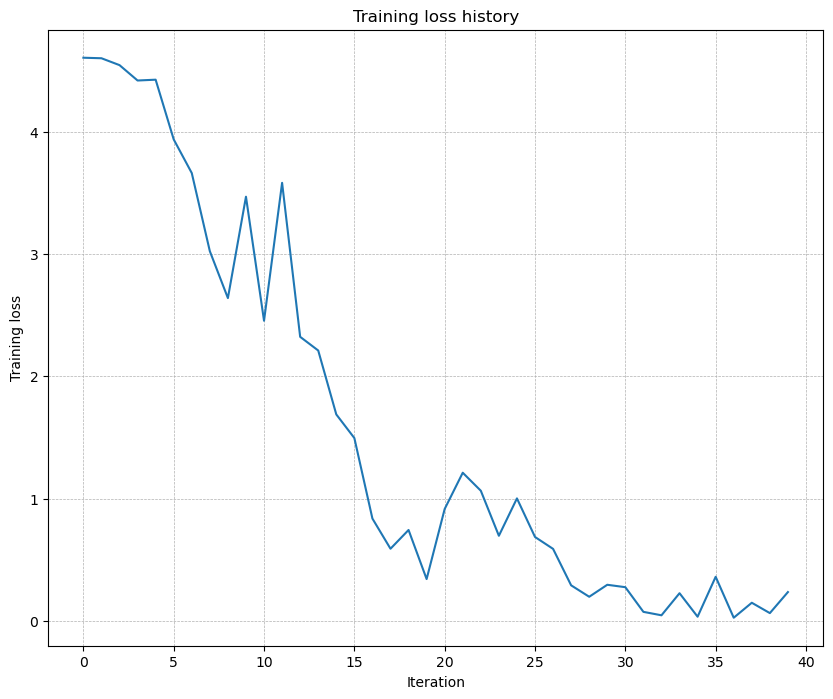

In [103]:
# TODO: Use a three-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 1e-5   # Experiment with this!

# model = FullyConnectedNet(
#     [100, 100],
#     weight_scale=weight_scale,
#     dtype=np.float64
# )
# solver = Solver(
#     model,
#     small_data,
#     print_every=10,
#     num_epochs=20,
#     batch_size=25,
#     update_rule="sgd", # sgd_momentum
#     optim_config={"learning_rate": learning_rate},
# )
# solver.train()
# best params: lr=1.947368e-03, reg=4.500000e-04

solver = None
# 随机参数交叉验证法 还是点交叉验证法，目的获取hyper-parameters
best_train_acc = 0
val_accuracy = 0
# update_rules = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']
update_rules = ['sgd']
weight_scale = 1e-3
learning_rate = 1e-4
lr_optimization_trial = 2  # 尝试 100 种不同的超参数组合
wd_optimization_trial = 1 
best_learnging_rate = 0
best_weigt_decay = 0
for update_rule in update_rules:
  for learning_rate in np.linspace(1.9e-03, 2e-3, lr_optimization_trial):
    for weight_decay in np.linspace(4.5e-04, 4.5e-04, wd_optimization_trial):
      # ----------------------------------------------------------
      # 在对数尺度上随机采样超参数
      # ----------------------------------------------------------
      # 学习率：10^(-7) 到 10^(-5) 之间
      # 使用对数尺度是因为学习率通常跨越多个数量级

      # 权重衰减：10^(-8) 到 10^(-4) 之间
      print("lr=%e, reg=%e, update_rule=%s" % (
            learning_rate, weight_decay, update_rule))
      model = FullyConnectedNet(
          [100, 100],
          weight_scale=weight_scale,
          dtype=np.float64
      )
      # inner_solver = Solver(model, data,
      #                 update_rule=update_rule,
      #                 optim_config={
      #                   'learning_rate':learning_rate,
      #                 },
      #                 lr_decay=0.95,
      #                 num_epochs=5,
      #                 batch_size=200, # mini-batch
      #                 print_every=24500)
      inner_solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule=update_rule, # sgd_momentum
          optim_config={"learning_rate": learning_rate},
      )
      inner_solver.train()
      if inner_solver.train_acc_history[-1] > best_train_acc:
          val_accuracy = inner_solver.val_acc_history[-1]
          best_learnging_rate = learning_rate
          best_weigt_decay = weight_decay
          best_train_acc = inner_solver.train_acc_history[-1]
          solver = inner_solver
print('Best params -> lr: %e reg: %e train acc: %f val acc: %f' % (
                    best_learnging_rate,
                    best_weigt_decay, best_train_acc,
                    val_accuracy))

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()



In [148]:
import importlib

def reload_modules():
    """手动重载常用模块"""
    import sys
    modules_to_reload = [m for m in sys.modules.keys() if m.startswith('cs231n')]
    for mod_name in modules_to_reload:
        importlib.reload(sys.modules[mod_name])

# 修改文件后调用
reload_modules()

Now, try to use a five-layer network with 100 units on each layer to overfit on 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

lr=4.000000e-04, reg=1.500000e+01, update_rule=sgd
(Iteration 1 / 40) loss: 4.605170
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 1 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 2 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 3 / 20) train acc: 0.120000; val_acc: 0.101000
(Epoch 4 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 5 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 11 / 40) loss: 4.604828
(Epoch 6 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 7 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 8 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 9 / 20) train acc: 0.120000; val_acc: 0.101000
(Epoch 10 / 20) train acc: 0.160000; val_acc: 0.079000
(Iteration 21 / 40) loss: 4.604713
(Epoch 11 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 12 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 13 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 14 / 20) train acc: 0.160000; val_acc: 0.079000
(Epoch 15 / 20) train acc: 0.1

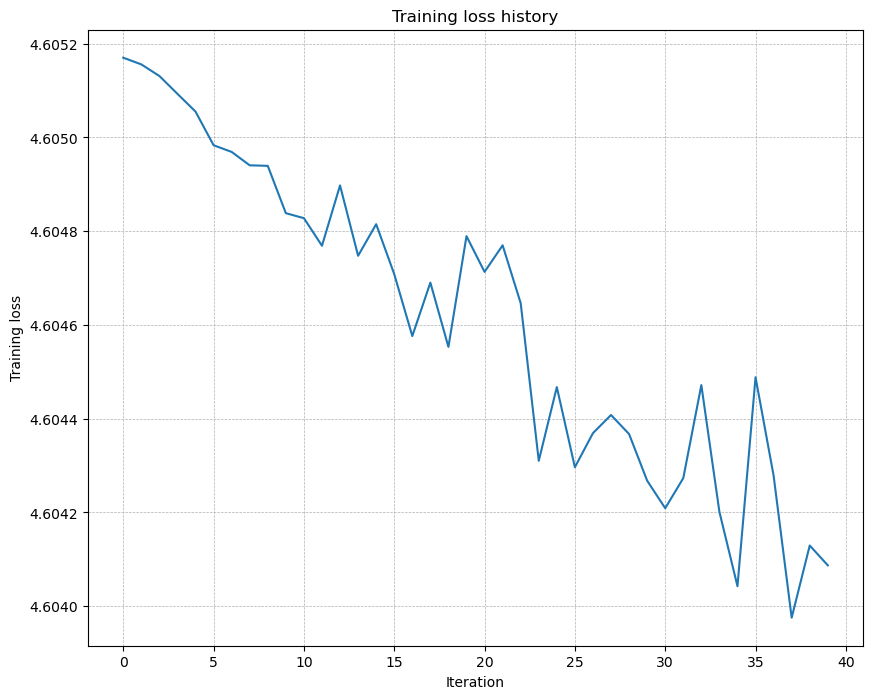

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# learning_rate = 2e-3  # Experiment with this!
# weight_scale = 1e-5   # Experiment with this!
best_train_acc = 0
val_accuracy = 0
# update_rules = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']
update_rules = ['sgd']
lr_optimization_trial = 30 # 尝试 100 种不同的超参数组合
wd_optimization_trial = 1
best_learnging_rate = 0
best_weigt_decay = 0
for update_rule in update_rules:
  for learning_rate in np.linspace(4e-4, 5e-4, lr_optimization_trial): # 4.828103e-04
    for weight_decay in np.linspace(1.5e1, 1.5e1, wd_optimization_trial):
      # ----------------------------------------------------------
      # 在对数尺度上随机采样超参数
      print("lr=%e, reg=%e, update_rule=%s" % (
            learning_rate, weight_decay, update_rule))
      model = FullyConnectedNet(
          [100, 100, 100, 100],
          weight_scale=weight_scale,
          dtype=np.float64
      )
      inner_solver = Solver(
          model,
          small_data,
          print_every=10,
          num_epochs=20,
          batch_size=25,
          update_rule=update_rule, # sgd_momentum
          optim_config={"learning_rate": learning_rate},
      )
      inner_solver.train()
      if inner_solver.train_acc_history[-1] > best_train_acc:
          val_accuracy = inner_solver.val_acc_history[-1]
          best_learnging_rate = learning_rate
          best_weigt_decay = weight_decay
          best_train_acc = inner_solver.train_acc_history[-1]
          solver = inner_solver
print('Best params -> lr: %e reg: %e train acc: %f val acc: %f' % (
                    best_learnging_rate,
                    best_weigt_decay, best_train_acc,
                    val_accuracy))

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

## Inline Question 1:
Did you notice anything about the comparative difficulty of training the three-layer network vs. training the five-layer network? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]
Traning the five-layer network is more difficult.Five-layer is more sensitive to initialize the scale of weight. 根据方差传播定律，var(out) = n * var(in) * var(weight)
如果weigh的方差设置过大，会导致var(out)过大，经过5层，方差会进一步放大，方差过大，也会导致梯度过大，梯度也难以学习，容易偏离正确的点。
还有一个问题 weight的期望值是0，每经过一层激活函数(ReLU)会导致，一半的数据梯度变为0, 层数据越多越难学习。
如果weight方差设置过小，会导致var(out)也会更得非常小，经过5次传播，最终的var(out)会非常小，会学习会变得非常困难，梯度会变得非常小。
网络的层数越大，越容易放大上面的问题。


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

你想了解**带动量的随机梯度下降（SGD with Momentum）**的具体公式，我会先从核心公式入手，再拆解各参数含义、更新逻辑，最后补充和普通SGD的区别，帮你彻底理解。

### 先明确核心前提
SGD with Momentum 是在普通随机梯度下降（SGD）的基础上，引入了「动量（Momentum）」的概念，模拟物理中的「惯性」——让参数更新不仅依赖当前批次的梯度，还依赖上一次的更新方向，从而加快收敛、减少震荡。

### 关键符号定义（先统一符号，避免混淆）
在深度学习参数更新中，常用符号约定如下：
| 符号 | 含义 |
|------|------|
| $\theta$ | 网络待更新的参数（如权重 $W$、偏置 $b$，可表示单个参数或参数矩阵） |
| $g_t$ | 第 $t$ 步（第 $t$ 个批次）计算得到的 $\theta$ 的梯度，即 $g_t = \nabla_\theta L(\theta_t)$（$L$ 为损失函数） |
| $v_t$ | 第 $t$ 步的「速度（动量）项」，记录历史更新方向的累积，是实现动量的核心变量 |
| $\mu$ | 动量系数（超参数），通常取值范围为 $[0.8, 0.99]$，默认常用 $0.9$ |
| $\eta$（或 $\alpha$） | 学习率（超参数），控制每一步更新的步长，如 $1e-3$、$1e-4$ |

### SGD with Momentum 完整公式（两步更新法）
带动量的SGD参数更新分为**两步**：先更新「速度项」，再用速度项更新「模型参数」，这是标准且最常用的形式（无冲量修正的基础版，也是实际工程中最常见的）。

#### 步骤 1：更新速度项（动量累积）
$$v_t = \mu \cdot v_{t-1} - \eta \cdot g_t$$
- 解读：速度项 $v_t$ 由两部分组成：
  1.  历史惯性部分：$\mu \cdot v_{t-1}$——继承上一步的速度，$\mu$ 越大，惯性越强，历史更新方向的影响越持久（比如 $\mu=0.9$ 表示保留 90% 的上一步速度）。
  2.  当前梯度部分：$-\eta \cdot g_t$——普通SGD的更新项，负号表示**梯度下降**（沿着梯度的反方向更新参数，以减小损失）。
- 初始化：第 0 步的速度项 $v_0 = 0$（无历史更新，初始速度为 0）。

#### 步骤 2：更新模型参数
$$\theta_{t+1} = \theta_t + v_t$$
- 解读：参数的更新量不再是普通SGD的 $-\eta \cdot g_t$，而是**累积了历史惯性的速度项 $v_t$**，相当于“带着历史惯性”沿着当前方向更新参数。

---

### 补充：带冲量修正（Nesterov Accelerated Gradient, NAG）的进阶公式
上述基础版是「普通动量」，还有一种更优的进阶版本——**Nesterov动量（又称“前瞻动量”）**，它会先利用历史动量“前瞻”一步参数，再计算梯度，能进一步减少震荡、加快收敛，公式略有调整：

#### 步骤 1：前瞻参数（利用历史动量预估下一步参数）
$$\theta_t^{temp} = \theta_t + \mu \cdot v_{t-1}$$

#### 步骤 2：基于前瞻参数计算梯度
$$g_t = \nabla_\theta L(\theta_t^{temp})$$

#### 步骤 3：更新速度项
$$v_t = \mu \cdot v_{t-1} - \eta \cdot g_t$$

#### 步骤 4：更新模型参数
$$\theta_{t+1} = \theta_t + v_t$$

- 核心差异：普通动量是“先算梯度，再累积惯性”，NAG是“先凭惯性前瞻，再算前瞻位置的梯度”，更能精准预判最优更新方向，在深层网络中表现更优。

### 公式的通俗解读（对比普通SGD）
1.  普通SGD的更新公式：$\theta_{t+1} = \theta_t - \eta \cdot g_t$——相当于“盲人走路”，每一步只根据当前脚下的路况（当前梯度）调整方向，容易在局部最优附近震荡，收敛慢。
2.  SGD with Momentum的更新公式：相当于“滑冰运动员”，每一步不仅根据当前路况（当前梯度），还带着之前的滑行惯性（历史速度），更容易冲过局部最优的“小坑”，收敛更快且震荡更少。

### 关键参数的作用说明
1.  动量系数 $\mu$：
    - 当 $\mu=0$ 时，$v_t = -\eta \cdot g_t$，此时退化为**普通SGD**，无动量效果。
    - 当 $\mu$ 接近 1 时（如 0.99），惯性极强，适合在训练后期稳定收敛；当 $\mu$ 偏小（如 0.8），惯性较弱，适合训练前期快速探索参数空间。
2.  学习率 $\eta$：
    - 和普通SGD一样，控制更新步长，但由于动量的“放大效应”，SGD with Momentum 的学习率通常可以略小于普通SGD，避免因惯性过大导致参数发散。

### 总结
1.  基础版SGD with Momentum 分两步更新：先累积动量（速度项）$v_t = \mu \cdot v_{t-1} - \eta \cdot g_t$，再更新参数 $\theta_{t+1} = \theta_t + v_t$。
2.  核心是通过速度项 $v_t$ 累积历史更新惯性，解决普通SGD收敛慢、易震荡的问题，$\mu=0$ 时退化为普通SGD。
3.  进阶版NAG通过“前瞻参数”计算梯度，收敛效果更优，核心差异是梯度计算的参数位置不同。

In [142]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 8.449493
(Epoch 0 / 5) train acc: 0.014000; val_acc: 0.021000
(Iteration 11 / 200) loss: 2.955613
(Iteration 21 / 200) loss: 2.358659
(Iteration 31 / 200) loss: 2.194538
(Epoch 1 / 5) train acc: 0.257000; val_acc: 0.208000
(Iteration 41 / 200) loss: 2.150172
(Iteration 51 / 200) loss: 2.123933
(Iteration 61 / 200) loss: 1.948602
(Iteration 71 / 200) loss: 1.970570
(Epoch 2 / 5) train acc: 0.319000; val_acc: 0.240000
(Iteration 81 / 200) loss: 2.088552
(Iteration 91 / 200) loss: 1.950980
(Iteration 101 / 200) loss: 1.799172
(Iteration 111 / 200) loss: 1.915007
(Epoch 3 / 5) train acc: 0.365000; val_acc: 0.284000
(Iteration 121 / 200) loss: 1.820826
(Iteration 131 / 200) loss: 1.736650
(Iteration 141 / 200) loss: 1.884473
(Iteration 151 / 200) loss: 1.813544
(Epoch 4 / 5) train acc: 0.379000; val_acc: 0.279000
(Iteration 161 / 200) loss: 1.799626
(Iteration 171 / 200) loss: 1.761884
(Iteration 181 / 200) loss: 1.614487
(Iteration 191 / 200) los

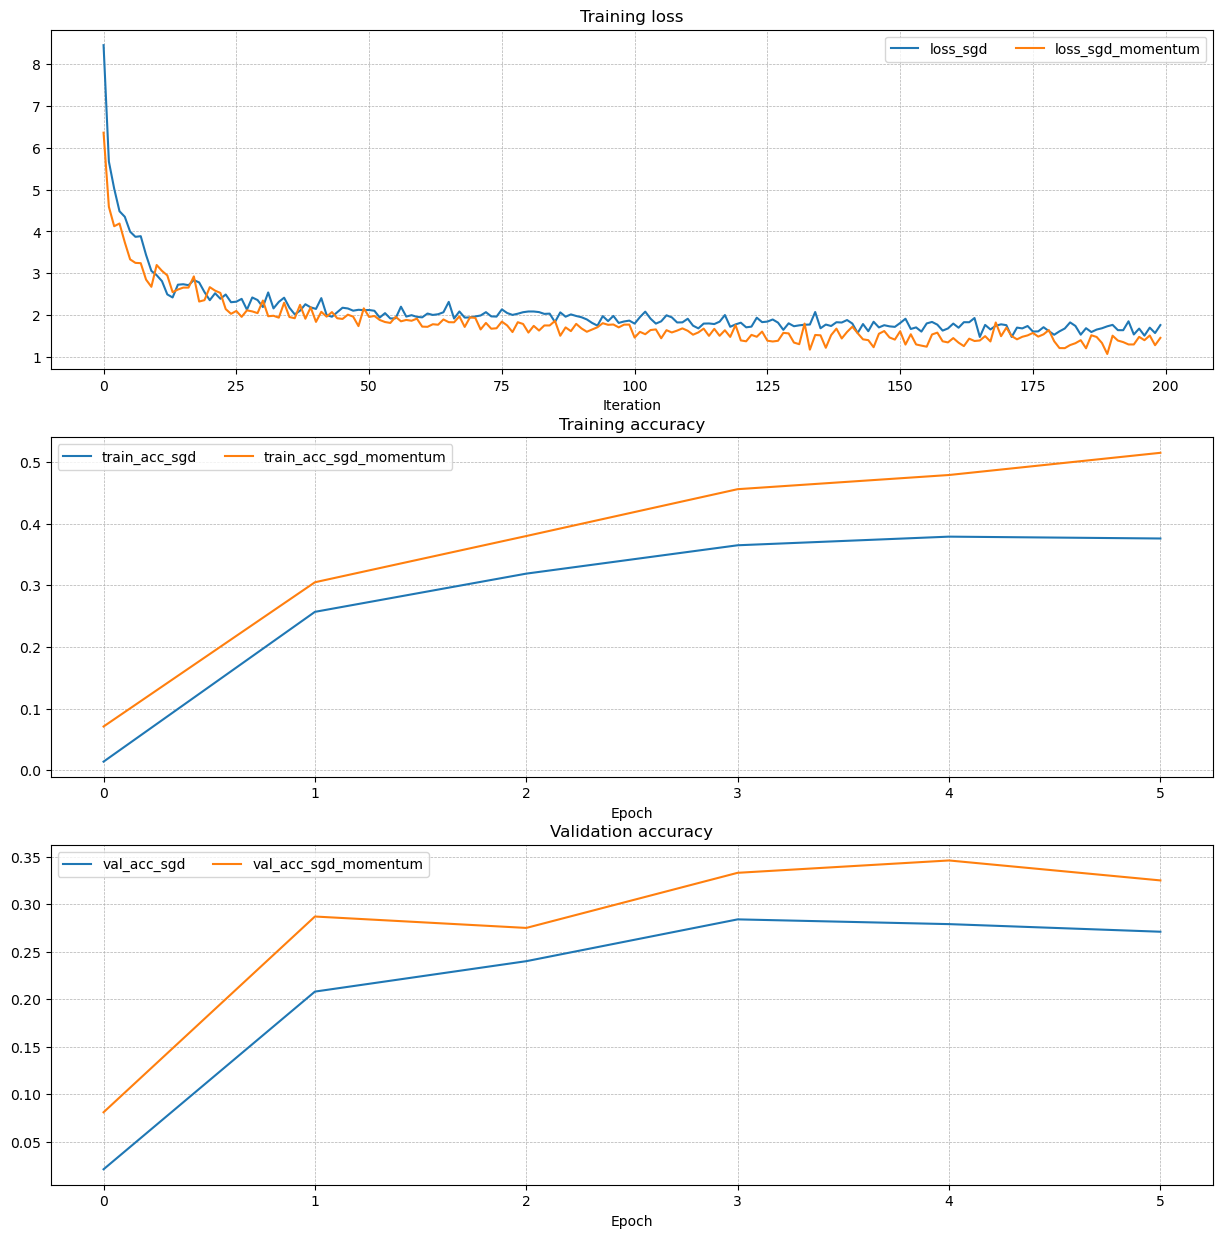

In [143]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")

for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

### RMSProp 核心公式（Hinton 原版，最常用）
RMSProp（Root Mean Square Propagation）是针对**Adagrad 学习率衰减过快**的改进版，核心是通过**指数移动平均（EMA）** 累积梯度的平方值，再用其平方根对梯度做**逐元素归一化**，从而自适应调整每个参数的学习率，解决非平稳目标的优化问题（适合RNN等时序模型）。

先统一**符号定义**（深度学习通用约定），再给出**三步核心更新公式**，公式是工程实现的标准形式：

#### 一、统一符号
| 符号 | 含义 |
|------|------|
| $\theta$ | 网络待更新参数（权重$W$/偏置$b$，单参数/参数矩阵均可） |
| $g_t$ | 第$t$步的参数梯度，$g_t = \nabla_\theta L(\theta_t)$（$L$为损失函数） |
| $E[g^2]_t$ | 第$t$步**梯度平方的指数移动平均**（核心累积项） |
| $\gamma$ | 衰减系数（超参数，控制历史梯度的保留比例），通常取$\boldsymbol{0.9}$ |
| $\eta$ | 全局学习率（超参数），通常取$0.001/0.01$ |
| $\epsilon$ | 极小值（数值稳定项，避免分母为0），通常取$\boldsymbol{10^{-8}}$ |
| $\Delta\theta_t$ | 第$t$步的参数更新量 |

#### 二、核心更新公式（3步，无偏差修正版，工程主流）
RMSProp 无复杂推导，核心是**累积梯度平方EMA→归一化梯度→更新参数**，**无偏差修正版**是实际框架（TensorFlow/PyTorch）中最常用的形式（Hinton原版也未做偏差修正）：
1. **初始化**：梯度平方的移动平均初始值为**0**，即 $E[g^2]_0 = 0$
2. **累积梯度平方的指数移动平均**（核心改进，替代Adagrad的直接累加）
   $$E[g^2]_t = \gamma \cdot E[g^2]_{t-1} + (1-\gamma) \cdot g_t^2$$
   （$g_t^2$ 是**梯度的逐元素平方**，不是矩阵平方；EMA让历史梯度的权重随步数指数衰减，避免累积过多）
3. **逐元素归一化梯度并更新参数**
   $$\Delta\theta_t = -\eta \cdot \frac{g_t}{\sqrt{E[g^2]_t + \epsilon}}$$
   $$\theta_{t+1} = \theta_t + \Delta\theta_t$$

### 补充：带偏差修正的RMSProp（可选，少用）
由于初始值 $E[g^2]_0=0$，训练初期的 $E[g^2]_t$ 会**偏小**（有偏估计），可加入**偏差修正项**消除初期偏差，公式仅修改第2步，其余不变：
$$E[g^2]_t = \gamma \cdot E[g^2]_{t-1} + (1-\gamma) \cdot g_t^2$$
$$\hat{E}[g^2]_t = \frac{E[g^2]_t}{1 - \gamma^t}$$
$$\theta_{t+1} = \theta_t - \eta \cdot \frac{g_t}{\sqrt{\hat{E}[g^2]_t + \epsilon}}$$
**说明**：训练后期 $t$ 增大，$\gamma^t \to 0$，修正项$\hat{E}[g^2]_t \approx E[g^2]_t$，修正效果可忽略；实际工程中几乎不用（Hinton原版也未提及），因为衰减系数$\gamma=0.9$时，初期偏差会快速消失。

### 关键超参数的取值（工程经验值）
RMSProp的超参数极少，且鲁棒性强（取值范围固定，无需大幅调参）：
- 衰减系数 $\gamma$：**0.9**（默认），也可取0.95/0.8，越大表示保留越多历史梯度信息
- 全局学习率 $\eta$：**0.001**（默认），时序模型（RNN/LSTM）常用0.001，CNN可尝试0.01
- 数值稳定项 $\epsilon$：**10⁻⁸**（默认），固定值，无需调整

### 核心设计思想（为什么比Adagrad好？）
1. **Adagrad的问题**：直接累加所有历史梯度平方 $\sum_{i=1}^t g_i^2$，导致学习率随步数**单调衰减至0**，训练后期参数几乎不更新；
2. **RMSProp的改进**：用**指数移动平均**替代**直接累加**，让历史梯度的权重按$\gamma^k$指数衰减（$k$为历史步数），相当于**只保留最近的一部分梯度信息**，避免学习率衰减过快，能适应**非平稳目标函数**（如时序数据的分布变化）。

### 公式的通俗解读
对每个参数而言，**梯度波动越大，学习率越小；梯度波动越小，学习率越大**：
- 若某参数的梯度长期偏大（平方累积值$E[g^2]_t$大），则分母$\sqrt{E[g^2]_t}$大，归一化后的梯度小→学习率自适应减小，避免参数更新震荡；
- 若某参数的梯度长期偏小（平方累积值$E[g^2]_t$小），则分母小，归一化后的梯度大→学习率自适应增大，让参数快速收敛。

### 与SGD-Momentum结合的RMSProp（工程常用升级版）
实际使用中，会将RMSProp的**自适应学习率**与SGD-Momentum的**动量惯性**结合，兼顾两者优势（Hinton也推荐此用法），公式仅在参数更新步加入动量项$v_t$（动量系数$\mu$通常取0.9）：
1. $E[g^2]_t = \gamma \cdot E[g^2]_{t-1} + (1-\gamma) \cdot g_t^2$
2. $v_t = \mu \cdot v_{t-1} + \frac{\eta \cdot g_t}{\sqrt{E[g^2]_t + \epsilon}}$（动量项融合归一化梯度）
3. $\theta_{t+1} = \theta_t - v_t$
这是工业界的**主流实现形式**，比纯RMSProp收敛更快、震荡更少。

### 总结
1. **原版核心公式（无偏差修正，工程首选）**：
   初始化$E[g^2]_0=0$ → $E[g^2]_t = 0.9\cdot E[g^2]_{t-1} + 0.1\cdot g_t^2$ → $\theta_{t+1} = \theta_t - \eta \cdot \frac{g_t}{\sqrt{E[g^2]_t + 10^{-8}}}$；
2. 核心改进是**指数移动平均累积梯度平方**，解决Adagrad学习率衰减过快问题；
3. 超参数鲁棒性极强，默认取$\gamma=0.9$、$\eta=0.001$、$\epsilon=10^{-8}$即可；
4. 工程中常与**动量**结合，兼顾自适应学习率和惯性收敛的优势。

In [150]:
# Test RMSProp implementation
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.502645229894295e-08
cache error:  2.6477955807156126e-09


In [151]:
# Test Adam implementation
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.139887467333134e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

Adam 可以理解为 **Momentum + RMSProp 的结合体**，同时维护**一阶矩（动量）**和**二阶矩（梯度平方的指数移动平均）**，并对两者做**偏差修正**。下面给出最标准、最常用的公式（PyTorch / TensorFlow 等框架默认实现）。

---

## 一、符号约定
- $\theta$：参数向量
- $g_t = \nabla_\theta L(\theta_t)$：第 $t$ 步的梯度
- $m_t$：梯度的**一阶矩估计**（指数移动平均，类似动量）
- $v_t$：梯度平方的**二阶矩估计**（指数移动平均，类似 RMSProp）
- $\beta_1$：一阶矩衰减率（默认 0.9）
- $\beta_2$：二阶矩衰减率（默认 0.999）
- $\eta$：学习率（默认 0.001）
- $\epsilon$：数值稳定项（默认 $10^{-8}$）

---

## 二、Adam 完整更新公式（4 步）

### 1. 初始化
$
m_0 = 0,\quad v_0 = 0
$

### 2. 更新一阶矩（动量）
$
m_t = \beta_1 \cdot m_{t-1} + (1-\beta_1) \cdot g_t
$

### 3. 更新二阶矩（梯度平方 EMA）
$
v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \cdot g_t^2
$
（$g_t^2$ 是逐元素平方）

### 4. 偏差修正（关键！Adam 独有）
$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$
$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$

### 5. 参数更新
$
\theta_{t+1} = \theta_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$

---

## 三、一句话理解 Adam
- **$m_t$**：带惯性的梯度方向（像 Momentum）
- **$v_t$**：自适应学习率分母（像 RMSProp）
- **偏差修正**：解决初期 $m_t, v_t$ 偏 0 的问题，让前期更稳定

---

## 四、默认超参数（工程常用）
$
\beta_1 = 0.9,\quad \beta_2 = 0.999,\quad \eta = 0.001,\quad \epsilon = 10^{-8}
$

---

## 五、和 RMSProp / Momentum 的关系
- Momentum：只用 $m_t$，无二阶矩、无修正
- RMSProp：只用 $v_t$，无一阶矩、通常无修正
- **Adam = Momentum + RMSProp + 双偏差修正**

Running with  adam

Running with  rmsprop



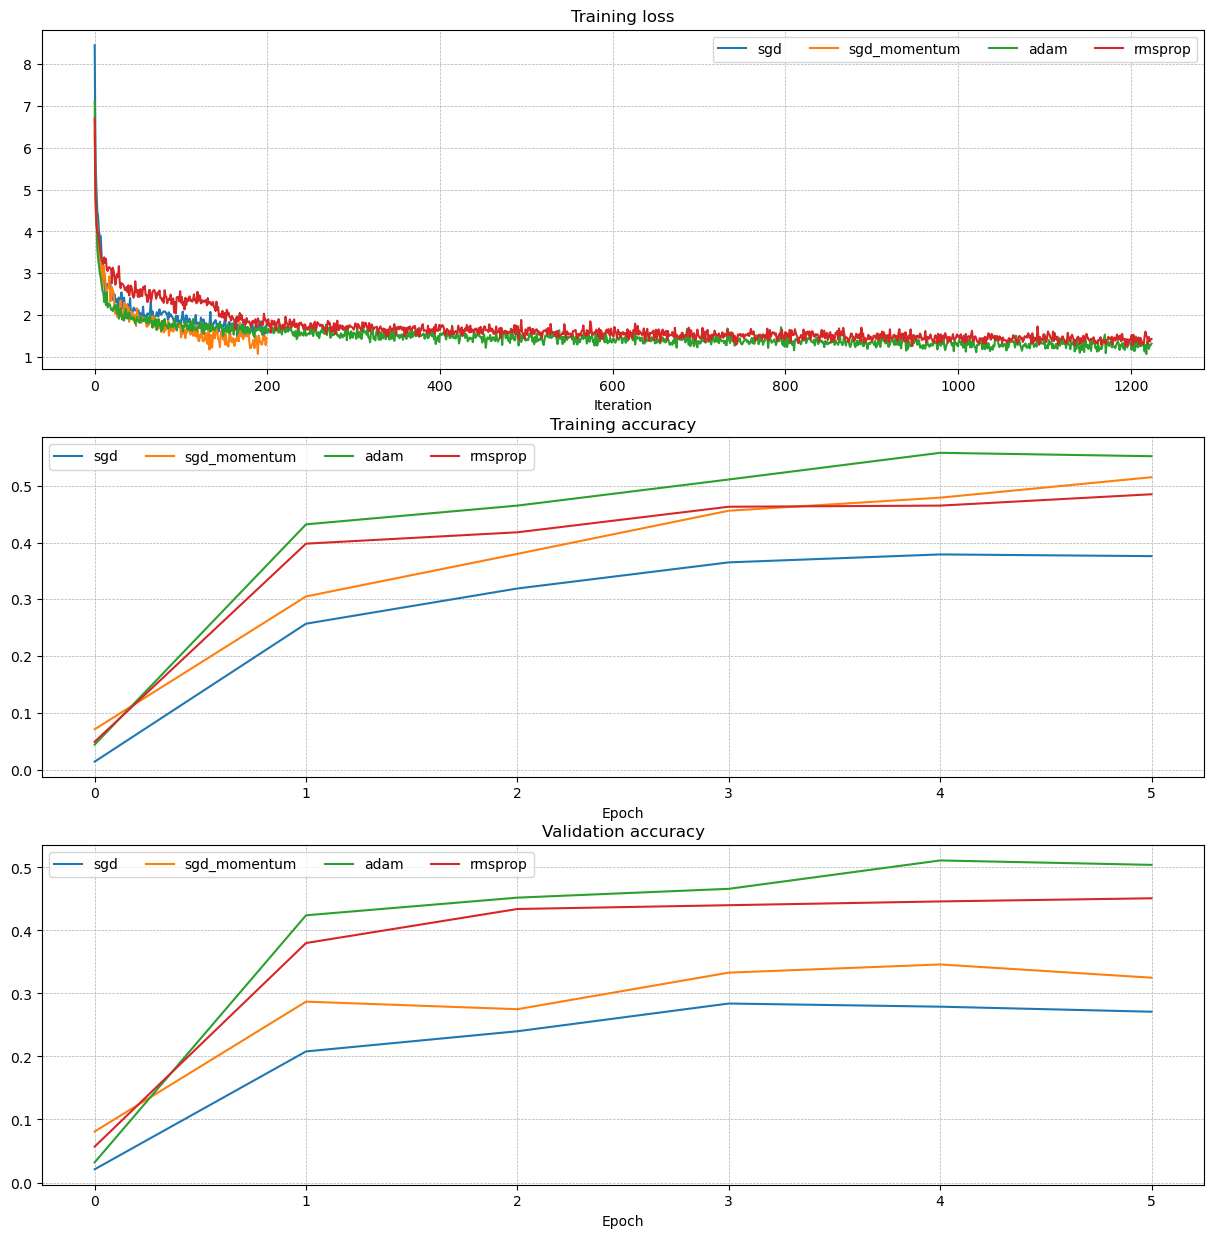

In [174]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        data,
        num_epochs=5,
        batch_size=200,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=False
    )
    solvers[update_rule] = solver
    solver.train()
    print()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")

for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

In [ ]:
import importlib

def reload_modules():
    """手动重载常用模块"""
    import sys
    modules_to_reload = [m for m in sys.modules.keys() if m.startswith('cs231n')]
    for mod_name in modules_to_reload:
        importlib.reload(sys.modules[mod_name])

# 修改文件后调用
reload_modules()
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver


## Inline Question 2:

AdaGrad, like Adam, is a per-parameter optimization method that uses the following update rule:

```
cache += dw**2
w += - learning_rate * dw / (np.sqrt(cache) + eps)
```

John notices that when he was training a network with AdaGrad that the updates became very small, and that his network was learning slowly. Using your knowledge of the AdaGrad update rule, why do you think the updates would become very small? Would Adam have the same issue?


## Answer:
cache will become bigger and bigger, so the result of $learning_rate * dw / (np.sqrt(cache) + eps)$ will become more small.
Adam will not be like this, because 分母和分子都在计算移动平均, 并对两者作了修正，不并会出现AdaGrad的问题



# Train a Good Model!
Train the best fully connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully connected network.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the next assignment, we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional networks rather than fully connected networks.

**Note:** In the next assignment, you will learn techniques like BatchNormalization and Dropout which can help you train powerful models.

In [163]:
for key,v in data.items():
    print("%s: %s " %(key, v.shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


lr=1.000000e-03, reg=5.000000e-02, update_rule=adam
(Iteration 1 / 1225) loss: 6.798685
(Epoch 0 / 5) train acc: 0.083000; val_acc: 0.100000
(Epoch 1 / 5) train acc: 0.422000; val_acc: 0.431000
(Epoch 2 / 5) train acc: 0.472000; val_acc: 0.455000
(Epoch 3 / 5) train acc: 0.509000; val_acc: 0.485000
(Epoch 4 / 5) train acc: 0.531000; val_acc: 0.469000
(Epoch 5 / 5) train acc: 0.547000; val_acc: 0.485000
lr=1.000000e-04, reg=5.000000e-02, update_rule=rmsprop
(Iteration 1 / 1225) loss: 5.977428
(Epoch 0 / 5) train acc: 0.071000; val_acc: 0.089000
(Epoch 1 / 5) train acc: 0.376000; val_acc: 0.362000
(Epoch 2 / 5) train acc: 0.438000; val_acc: 0.408000
(Epoch 3 / 5) train acc: 0.451000; val_acc: 0.419000
(Epoch 4 / 5) train acc: 0.478000; val_acc: 0.436000
(Epoch 5 / 5) train acc: 0.469000; val_acc: 0.445000
Best params -> lr: 1.000000e-03 reg: 5.000000e-02 train acc: 0.547000 val acc: 0.485000


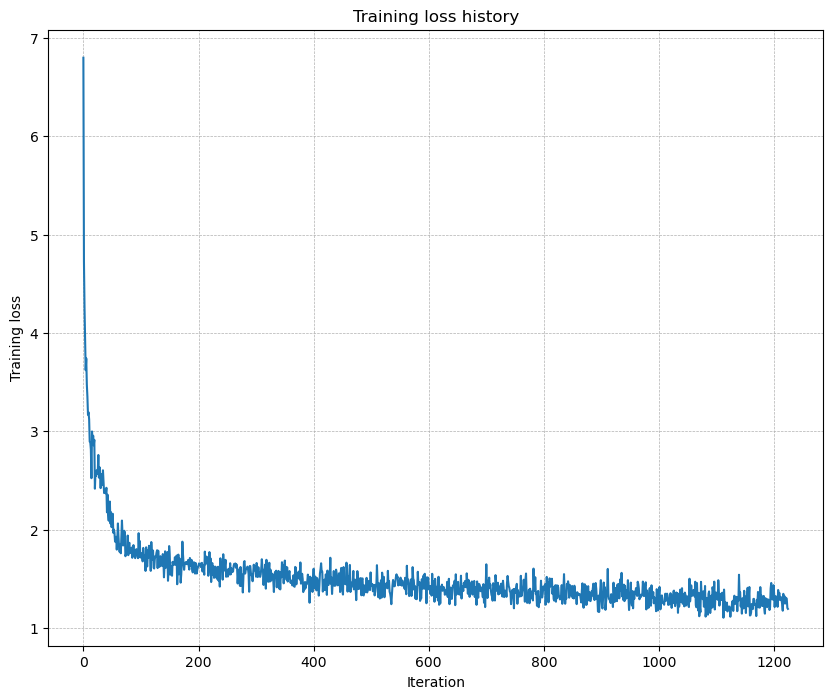

In [172]:
best_model = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


# learning_rate = 2e-3  # Experiment with this!
# weight_scale = 1e-5   # Experiment with this!
best_train_acc = 0
val_accuracy = 0
update_rules = ['rmsprop', 'adam']
# update_rules = ['sgd']
# lr_optimization_trial = 2 # 尝试 100 种不同的超参数组合
wd_optimization_trial = 1
best_learnging_rate = 0
best_weigt_decay = 0
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    for weight_decay in np.linspace(5e-2, 5e-2, wd_optimization_trial):
      learning_rate = learning_rates[update_rule]
      # ----------------------------------------------------------
      # 在对数尺度上随机采样超参数
      print("lr=%e, reg=%e, update_rule=%s" % (
            learning_rate, weight_decay, update_rule))
      model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        # weight_scale=5e-2
          weight_scale=weight_decay,
          dtype=np.float64
      )
      inner_solver = Solver(
          model,
          data, # 总共49000个训练数据
          print_every=1225,
          num_epochs=5, # 每个训练，跑20个epoch,每个epoch会使用所有训练数据
          batch_size=200, # 每个批200个, 所以每epoch会跑 train_set_nums / batch_size 批次
                          # 每个epoch 会验证测试集的所有数据
          update_rule=update_rule, # sgd_momentum
          optim_config={"learning_rate": learning_rate},
      )
      inner_solver.train()
      if inner_solver.train_acc_history[-1] > best_train_acc:
          val_accuracy = inner_solver.val_acc_history[-1]
          best_learnging_rate = learning_rate
          best_weigt_decay = weight_decay
          best_train_acc = inner_solver.train_acc_history[-1]
          solver = inner_solver
          best_model = model
print('Best params -> lr: %e reg: %e train acc: %f val acc: %f' % (
                    best_learnging_rate,
                    best_weigt_decay, best_train_acc,
                    val_accuracy))

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test Your Model!
Run your best model on the validation and test sets. You should achieve at least 50% accuracy on the validation set and the test set.

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())